In [1]:
import spatialproteomics as sp
from skimage.io import imread
import matplotlib.pyplot as plt
from scipy.signal import medfilt2d
import pandas as pd
import time
import gc
import anndata

## 0 - Open image and crop out tissue

In [2]:
img_path = "/lustre/scratch127/cellgen/cellgeni/tickets/tic-4225/data/ob02832_Scan1.qptiff"
image = imread(img_path)
image.shape

(61, 59760, 33600)

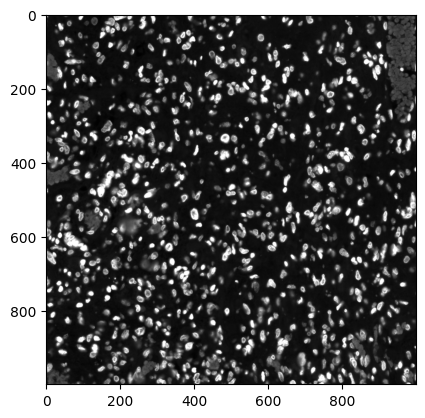

In [3]:
crop = image[:,25000:26000, 10000:11000]
plt.imshow(crop[0,:,:], cmap = 'gray')

## 1 - Initiate sp object and image preprocessing

In [4]:
list_of_channels = ["DAPI", "Keratin 14", "CD107", "CD4", "CD31", "SMA", "CD68", "CD44", "Vimentin", 
                    "CD66", "E-cadherin", "IDO1", "CD45RO", "IFNG", "CD21", "CD11c", "CD45", "HLA-DR", 
                    "CD34", "iNOS", "CD38", "Histone H3 (p Ser28)", "CD8", "PCNA", "FOXP3", "CD57", "Ki67", 
                    "Granzyme-B", "HLA-A", "CD20", "Collagen IV", "CD14", "Pan-Cytokeratin", "PD-1", "VISTA", 
                    "Keratin 8/18", "TCF-1", "Lag3", "Caveolin", "ICOS", "TOX", "EpCAM", "PD-L1", 
                    "CD163", "Keratin 5", "CD3e", "ER", "Beta-actin", "Bcl-2", "CD79a", "CD56", "GP100", 
                    "TP63", "b-Catenin1", "CD209", "MPO", "CD11b", "CD39", "SOX2", "Podoplanin", "CD206"]
sp_object = sp.load_image_data(crop, channel_coords=list_of_channels)
sp_object

<xarray.Dataset> Size: 61MB
Dimensions:   (channels: 61, y: 1000, x: 1000)
Coordinates:
  * channels  (channels) <U20 5kB 'DAPI' 'Keratin 14' ... 'Podoplanin' 'CD206'
  * y         (y) int64 8kB 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * x         (x) int64 8kB 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    _image    (channels, y, x) uint8 61MB 168 144 150 140 112 82 ... 3 1 2 3 3 4

In [5]:
del image
import gc
gc.collect()

10390

### performing Otsu thresholding on all channels

In [6]:
thrs_list = sp.pp.otsu_per_channel(crop, channel_axis=0)
sp_object = sp_object.pp.threshold(intensity=thrs_list).pp.apply(medfilt2d, kernel_size=3)

Original shape: (61, 1000, 1000)
channel_axis: 0
Shape after moveaxis: (1000, 1000, 61)
Number of channels interpreted: 61


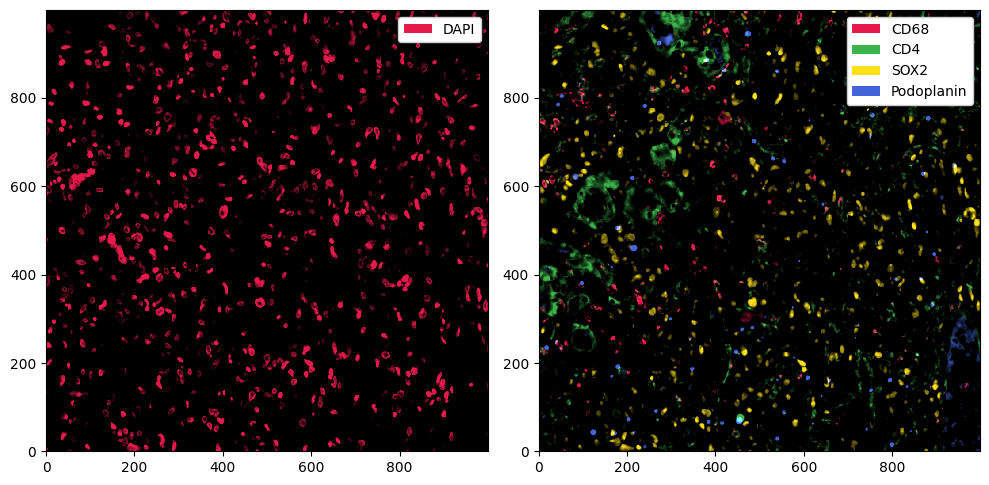

In [7]:
#lets see some genes

list_of_genes_display = ['CD68', 'CD4', 'SOX2', 'Podoplanin']
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# create axes explicitly and pass them
_ = sp_object.pp[["DAPI"]].pl.show(ax=ax[0])
_ = sp_object.pp[list_of_genes_display].pl.show(ax=ax[1])
fig.tight_layout()


In [10]:
import xarray as xr
sp_object = xr.open_zarr("sp_obj_checkpoint.zarr")

## 2 - Segmentation and area filtering

In [11]:
sp_object = sp_object.tl.stardist(channel='DAPI')
areas = sp_object.pp.add_observations("area").pp.get_layer_as_df()["area"]


Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


100%|██████████| 144/144 [00:17<00:00,  8.22it/s]


(array([115., 115.,  68.,  65.,  51.,  65.,  45.,  60.,  43.,  51.,  49.,
         48.,  49.,  35.,  31.,  46.,  29.,  32.,  26.,  14.,  19.,   7.,
         13.,  10.,   8.,   8.,   7.,   3.,   3.,   2.,   1.,   3.,   2.,
          3.,   1.,   2.,   1.,   0.,   0.,   2.,   0.,   0.,   1.,   1.,
          0.,   1.,   0.,   0.,   1.,   1.]),
 array([  5.  ,  15.04,  25.08,  35.12,  45.16,  55.2 ,  65.24,  75.28,
         85.32,  95.36, 105.4 , 115.44, 125.48, 135.52, 145.56, 155.6 ,
        165.64, 175.68, 185.72, 195.76, 205.8 , 215.84, 225.88, 235.92,
        245.96, 256.  , 266.04, 276.08, 286.12, 296.16, 306.2 , 316.24,
        326.28, 336.32, 346.36, 356.4 , 366.44, 376.48, 386.52, 396.56,
        406.6 , 416.64, 426.68, 436.72, 446.76, 456.8 , 466.84, 476.88,
        486.92, 496.96, 507.  ]),
 <BarContainer object of 50 artists>)

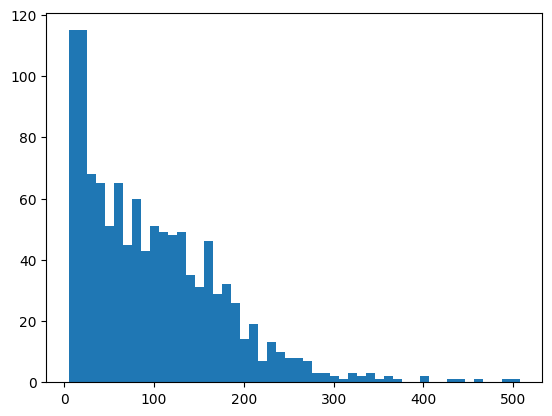

In [14]:
plt.hist(areas, bins = 50)

### lets plot segmentation mask just before and after filtering

Text(0.5, 1.0, 'before filtering')

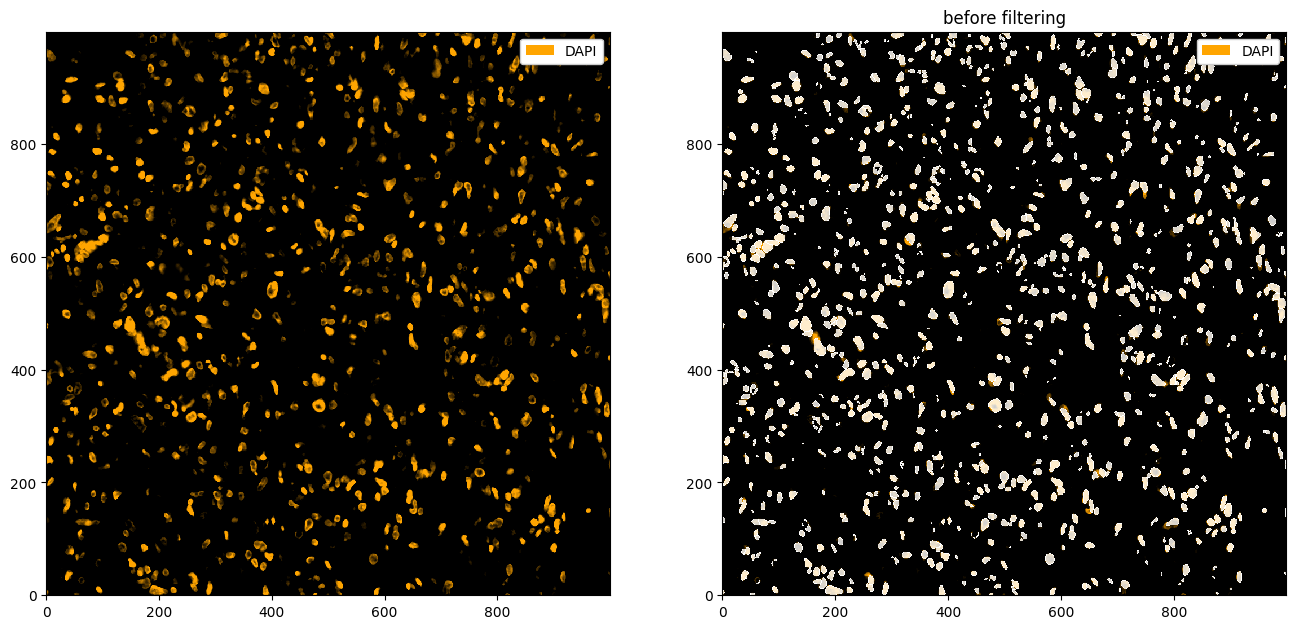

In [33]:
fix, ax = plt.subplots(1, 2, figsize=(16, 8))
_ = sp_object.pp["DAPI"].pl.colorize("orange").pl.show(ax=ax[0])
_ = sp_object.pp["DAPI"].pl.colorize("orange").pl.show(render_segmentation=True, ax=ax[1], segmentation_kwargs={'alpha': 0.8})
plt.title('before filtering')


Text(0.5, 1.0, 'after filtering')

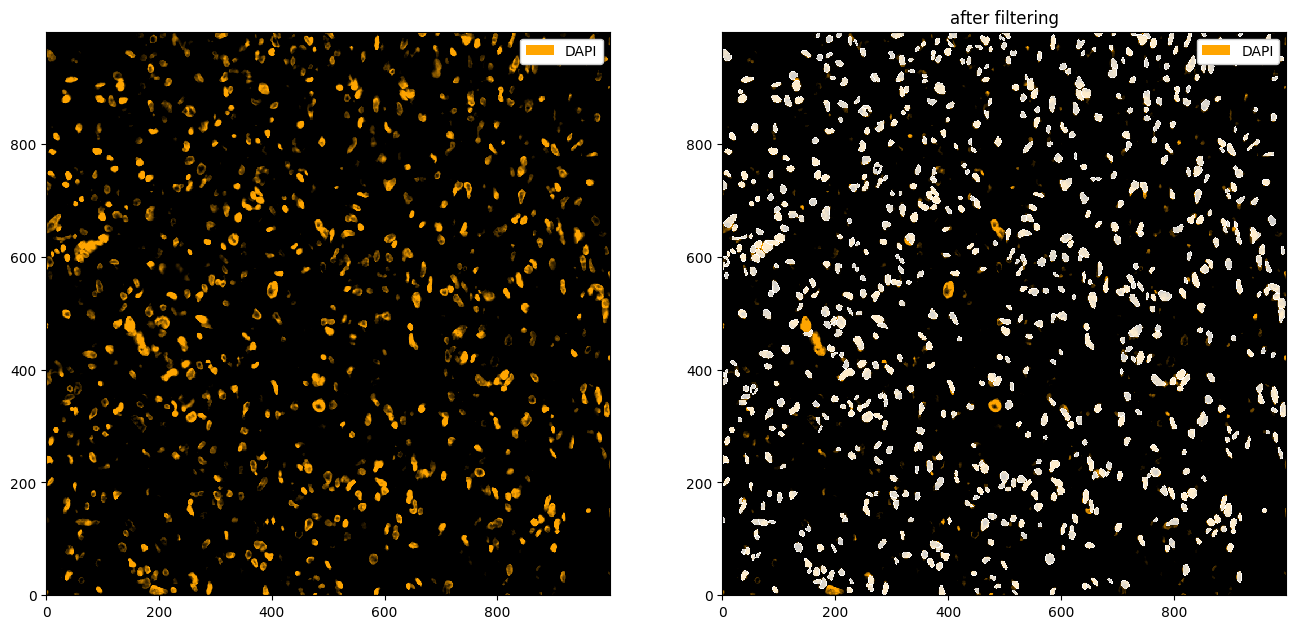

In [35]:
min_area = 50
max_area = 400
sp_object = sp_object.pp.add_observations("area")
sp_object = sp_object.pp.filter_by_obs("area", lambda x: x > min_area)
sp_object = sp_object.pp.filter_by_obs("area", lambda x: x < max_area)


fix, ax = plt.subplots(1, 2, figsize=(16, 8))
_ = sp_object.pp["DAPI"].pl.colorize("orange").pl.show(ax=ax[0])
_ = sp_object.pp["DAPI"].pl.colorize("orange").pl.show(render_segmentation=True, ax=ax[1], segmentation_kwargs={'alpha': 0.8})
plt.title('after filtering')


## 3 - extracting average intensity per cell per channel

In [36]:
## normalisation requires custom code from run_AKOYA
from run_AKOYA import normalize_intensities

sp_object = sp_object.pp.add_quantification(func="intensity_mean").pp.transform_expression_matrix(method="arcsinh")

sp_object = normalize_intensities(sp_object)
sp_object


<xarray.Dataset> Size: 66MB
Dimensions:         (channels: 61, x: 1000, y: 1000, features: 3, cells: 740)
Coordinates:
  * channels        (channels) <U20 5kB 'DAPI' 'Keratin 14' ... 'CD206'
  * x               (x) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * y               (y) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * features        (features) <U10 120B 'area' 'centroid-0' 'centroid-1'
  * cells           (cells) int64 6kB 1 2 3 4 5 6 7 ... 735 736 737 738 739 740
Data variables:
    _image          (channels, y, x) uint8 61MB 0 42 36 8 0 0 0 ... 0 0 0 0 0 0
    _obs            (cells, features) float64 18kB 269.0 63.34 ... 662.8 225.9
    _segmentation   (y, x) int32 4MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    _intensity      (cells, channels) float64 361kB -0.6396 -0.1929 ... -0.4354
    _intensity_raw  (cells, channels) float64 361kB 3.13 0.2125 ... 0.0 0.0623

In [39]:
df = sp_object["_intensity"].compute().to_pandas()
df.head()

channels,DAPI,Keratin 14,CD107,CD4,CD31,SMA,CD68,CD44,Vimentin,CD66,...,GP100,TP63,b-Catenin1,CD209,MPO,CD11b,CD39,SOX2,Podoplanin,CD206
cells,,,,,,,,,,,,,,,,,,,,,
1,-0.639579,-0.192879,0.0,-0.528145,-0.170626,-0.158517,-0.307815,-1.057850,-0.079927,-0.101026,...,-0.069433,-0.729308,-0.679409,-0.439154,-0.082358,-0.783634,-0.456872,1.282801,-0.215493,-0.390724
2,-0.010797,-0.307874,0.0,1.556495,-0.170626,-0.158517,-0.307815,-1.288838,-1.195036,-0.618743,...,-0.069433,-0.729308,-0.679409,-1.213231,-0.082358,0.025492,-0.180867,-1.016785,-0.215493,-0.856766
3,1.208361,-0.775535,0.0,-0.466322,-0.170626,-0.158517,-0.307815,0.927902,-0.432363,0.292925,...,-0.069433,-0.583847,-0.645946,1.970387,-0.082358,0.210413,-0.377456,-0.784997,-0.215493,-0.202957
4,0.191777,-0.534503,0.0,-0.099367,1.724528,-0.158517,-0.279605,-1.288838,-1.272114,-0.659467,...,-0.069433,-0.729308,-0.380461,-0.687899,-0.082358,-0.459238,0.363197,-1.016785,-0.215493,-0.814131
5,0.398910,-1.051105,0.0,-0.528145,-0.170626,-0.158517,-0.307815,-0.578370,-1.263488,-0.567082,...,-0.069433,-0.729308,-0.649971,-0.891764,-0.082358,-0.852209,-0.456872,-0.636406,-0.215493,-0.895647


In [41]:
df = sp_object["_intensity_raw"].compute().to_pandas()
df.head()

channels,DAPI,Keratin 14,CD107,CD4,CD31,SMA,CD68,CD44,Vimentin,CD66,...,GP100,TP63,b-Catenin1,CD209,MPO,CD11b,CD39,SOX2,Podoplanin,CD206
cells,,,,,,,,,,,,,,,,,,,,,
1,3.130302,0.212523,0.0,0.000000,0.000000,0.0,0.000000,0.293892,1.078224,0.097244,...,0.0,0.000000,0.000000,0.470212,0.0,0.083175,0.000000,3.325073,0.0,0.068348
2,3.424295,0.184047,0.0,0.781230,0.000000,0.0,0.000000,0.000000,0.098088,0.009649,...,0.0,0.000000,0.000000,0.216721,0.0,0.806910,0.105942,0.000000,0.0,0.005263
3,3.994324,0.068240,0.0,0.023169,0.000000,0.0,0.000000,2.820424,0.768447,0.163899,...,0.0,0.102261,0.018292,1.259280,0.0,0.972316,0.030483,0.335154,0.0,0.093765
4,3.519010,0.127927,0.0,0.160687,0.506358,0.0,0.011034,0.000000,0.030340,0.002759,...,0.0,0.000000,0.163410,0.388754,0.0,0.373336,0.314776,0.000000,0.0,0.011034
5,3.615857,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.903949,0.037922,0.018390,...,0.0,0.000000,0.016091,0.321993,0.0,0.021837,0.000000,0.550008,0.0,0.000000


## 4 - constructing binary marker gene presence matrix


In [42]:
threshold_positive_pixels = 0.5
list_of_markers = ["CD66", "E-cadherin", "SOX2", "CD45RO", "IFNG", "CD44"]
sp_object = sp_object.pp.add_quantification(func=sp.percentage_positive, key_added="_percentage_positive")
threshold_dict  = {k: threshold_positive_pixels for k in list_of_markers}
sp_object = sp_object.la.threshold_labels(threshold_dict, layer_key="_percentage_positive")
sp_object

<xarray.Dataset> Size: 66MB
Dimensions:               (channels: 61, x: 1000, y: 1000, features: 9,
                           cells: 740)
Coordinates:
  * channels              (channels) <U20 5kB 'DAPI' 'Keratin 14' ... 'CD206'
  * x                     (x) int64 8kB 0 1 2 3 4 5 ... 994 995 996 997 998 999
  * y                     (y) int64 8kB 0 1 2 3 4 5 ... 994 995 996 997 998 999
  * features              (features) <U20 720B 'CD44_binarized' ... 'centroid-1'
  * cells                 (cells) int64 6kB 1 2 3 4 5 6 ... 736 737 738 739 740
Data variables:
    _image                (channels, y, x) uint8 61MB 0 42 36 8 0 ... 0 0 0 0 0
    _obs                  (cells, features) float64 53kB 0.0 0.0 ... 662.8 225.9
    _segmentation         (y, x) int32 4MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    _intensity            (cells, channels) float64 361kB -0.6396 ... -0.4354
    _intensity_raw        (cells, channels) float64 361kB 3.13 0.2125 ... 0.0623
    _percentage_positive  (cells, channels) float64 361kB 0.9628 ... 0.2727

In [48]:
df = sp_object["_obs"].compute().to_pandas()
df.head()


features,CD44_binarized,CD45RO_binarized,CD66_binarized,E-cadherin_binarized,IFNG_binarized,SOX2_binarized,area,centroid-0,centroid-1
cells,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,1.0,269.0,63.338290,580.739777
2,0.0,0.0,0.0,0.0,0.0,0.0,228.0,496.824561,373.732456
3,1.0,1.0,1.0,1.0,0.0,0.0,164.0,128.396341,866.725610
4,0.0,0.0,0.0,0.0,0.0,0.0,145.0,529.896552,137.041379
5,0.0,0.0,0.0,0.0,0.0,0.0,174.0,128.500000,72.747126


## 5 - saving

In [49]:
#save as xarray zarr object
path_zarr = "sp_object.zarr"
sp_object.to_zarr(path_zarr, mode="w", zarr_version=2, consolidated=True)

2135949155.py (2): zarr_version is deprecated, use zarr_format


In [2]:
#save all tables - use function from run_AKOYA.py
from run_AKOYA import write_tables_csv

path_dir = 'folder_with_tables'
write_tables_csv(sp_object, path_dir)

Skipping _image (huge image/mask)
Saved folder_with_tables/_intensity.csv  shape=(7672, 61)
Saved folder_with_tables/_intensity_raw.csv  shape=(7672, 61)
Saved folder_with_tables/_obs.csv  shape=(7672, 29)
Saved folder_with_tables/_percentage_positive.csv  shape=(7672, 61)
Skipping _segmentation (huge image/mask)


In [3]:
#save in h5ad anndata format - use function from run_AKOYA.py
from run_AKOYA import spobject_to_anndata

pixelsize = 0.51 # used to save all positions in microns
spot_diameter_fullres=20.0 # this is needed for visualisation only with squidpy.pl.spatial_scatter
image_downsample=10 #whole image is usually huge, so save just downsampled version of it

spobject_to_anndata(sp_object, out_dir=path_dir, sample_id="anndata", image_downsample=image_downsample,
                            image_channels=["DAPI"],spot_diameter_fullres=spot_diameter_fullres, pixel_size_um = pixelsize) 

Saved anndata object at folder_with_tables/anndata.h5ad


(AnnData object with n_obs × n_vars = 7672 × 61
     obs: 'CD11b_binarized', 'CD11c_binarized', 'CD14_binarized', 'CD163_binarized', 'CD206_binarized', 'CD209_binarized', 'CD21_binarized', 'CD31_binarized', 'CD39_binarized', 'CD3e_binarized', 'CD45RO_binarized', 'CD4_binarized', 'CD66_binarized', 'CD68_binarized', 'CD79a_binarized', 'CD8_binarized', 'Granzyme-B_binarized', 'IDO1_binarized', 'IFNG_binarized', 'Ki67_binarized', 'MPO_binarized', 'SMA_binarized', 'SOX2_binarized', 'TCF-1_binarized', 'TOX_binarized', 'VISTA_binarized', 'area', 'centroid-0', 'centroid-1'
     uns: 'spatial'
     obsm: 'spatial', 'spatial_um',
 'folder_with_tables/anndata.h5ad')